## Sales Forecasting Notebook

In this Notebook I will be applying machine learning techniques to the Predict Future Sales dataset. This dataset consists of time series for a large number of products at various store locations. The goal is to predict the monthly sales for each item and store for the final month in the dataset.

### 1 - Data Loading and Exploration

First I load the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle as pkl
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import re
from datetime import datetime
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Next, I load the necessary files:

In [16]:
train = pd.read_csv('sales_train.csv')

In [17]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Since the company providing this data is a Russian company, all the item names, category names, and store names are in Russian. I used a Python Google Translate interface prior to creating this notebook in order to get the English names for some analysis. I also combined some of the item categories into broader categories in order to find more meaningful item groupings.

In [94]:
items = pd.read_csv('items_english.csv',index_col=0)
cats = pd.read_csv('item_categories.csv',index_col=0)
shops = pd.read_csv('shops.csv',index_col=0)

In [95]:
items.head()

,item_name,item_id,item_category_id,english_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! In the power of obsession (plast.) D
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,! Abbyy Finereader 12 Professional Edition Ful...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,*** In the rays of glory (unv) D
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,*** Blue wave (univ) D
4,***КОРОБКА (СТЕКЛО) D,4,40,*** Box (glass) D


In [20]:
cats.head()

,item_category_name,item_category_id,english,supercategory,megacategory
0,PC - Гарнитуры/Наушники,0,PC - Headsets/Headphones,0,0
1,Аксессуары - PS2,1,Accessories - PS2,1,0
2,Аксессуары - PS3,2,Accessories - PS3,1,0
3,Аксессуары - PS4,3,Accessories - PS4,1,0
4,Аксессуары - PSP,4,Accessories - PSP,1,0


In [21]:
shops.head()

,shop_name,shop_id,english_name,location
0,"!Якутск Орджоникидзе, 56 фран",0,"! Yakutsk Ordzhonikidze, 56 fran",0
1,"!Якутск ТЦ ""Центральный"" фран",1,"! Yakutsk shopping center ""central"" fran",0
2,"Адыгея ТЦ ""Мега""",2,"Adygea shopping center ""mega""",1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"Balashikha TRK ""October-Kinomir""",2
4,"Волжский ТЦ ""Волга Молл""",4,"Volzhsky shopping center ""Volga Mall""",3


The test set contains the shop and item combinations I wish to predict the sales for. The month is November, 2015.

In [22]:
test = pd.read_csv('test.csv')

In [23]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


First, I check the train set for null values, there are none, so I can move onto the next step.

In [24]:
train.isna().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

Here, I check for item duplicates via comparing English names of items. This process isn't perfect since the translation is not perfect, but it can serve as an initial filter for duplicate values, which I can then evaluate by eye. 

In [25]:
items['english_name'] = items['english_name'].str.lower()

In [26]:
items[items.duplicated(['english_name'],keep=False)].head(50)

,item_name,item_id,item_category_id,english_name
2514,DEEP PURPLE Come Hell Or High Water DVD,2514,59,deep purple come hell or high water dvd
2558,DEEP PURPLE Come Hell Or High Water DVD,2558,59,deep purple come hell or high water dvd
2968,"Divinity: Dragon Commander [PC, Цифровая версия]",2968,31,"divinity: dragon commander [pc, digital version]"
2970,"Divinity: Dragon Commander [PC, Цифровая версия]",2970,31,"divinity: dragon commander [pc, digital version]"
5061,NIRVANA Unplugged In New York LP,5061,58,nirvana unplugged in new york lp
5063,NIRVANA Unplugged In New York LP,5063,58,nirvana unplugged in new york lp
5837,Pokemon XY Стартовый набор,5837,65,pokemon xy starting set
5838,Pokemon XY Стартовый набор Калоса,5838,65,pokemon xy starting set
6027,RED HOT CHILI PEPPERS Californication,6027,55,red hot chili peppers californication
6029,RED HOT CHILI PEPPERS Californication (фирм.),6029,56,red hot chili peppers californication


In [27]:
dupes = items[items.duplicated(['english_name'],keep=False)]

In [28]:
dupes[100:150]

,item_name,item_id,item_category_id,english_name
13376,"Компл.вопр.серт.экзам.1С:Документооборот 8, ию...",13376,49,complete the surgical service. exprietary.
13383,"Компл.вопр.серт.экзам.1С:Пр.8.УПП (ред.1.3), м...",13383,49,complete the surgical serpram.
13387,Компл.вопр.серт.экзам.1С:Профессионал по техно...,13387,49,complete the surgical service. exprietary.
13389,Компл.вопр.серт.экзам.1С:Управление небольшой ...,13389,49,complete the surgical service. exprietary.
13390,Компл.вопр.серт.экзам.1С:Управление небольшой ...,13390,49,complete the surgical service. exprietary.
13391,Компл.вопр.серт.экзам.1С:Управление небольшой ...,13391,49,complete the surgical service. exprietary.
13804,ЛЕВША,13804,40,left
13958,ЛОВЕЦ СНОВ (BD),13958,37,dreams (bd)
14044,ЛЮБИТ НЕ ЛЮБИТ,14044,40,love does not love
14045,ЛЮБИТ/НЕ ЛЮБИТ,14045,40,love does not love


Some of these duplicates are legitimately the same item, whereas others are the result of faulty translation. 

The code below allows me to visualize the sales of duplicate items over the relevant months. A consistent pattern is that one of the duplicate items is sold in the earlier months, with and the other is sold in the later ones, with a consistent sales pattern throughout, indicating that these are indeed the same item and have been mislabeled.

In a real-life scenario, it would be necessary to deal with these duplicate values, either via dropping one, or preferably by combining them in a way that makes sense. However, since the test data is also expecting some predictions for duplicated values, it makes more sense to leave them as they are for this exercise.

In [29]:
train['item_id'] = train['item_id'].astype('int16')

In [30]:
train_dupes = train[['date_block_num','item_id','item_cnt_day']].groupby(['date_block_num','item_id']).sum().reset_index(drop=False)

In [31]:
train_dupes = train_dupes[train_dupes.item_id.isin(dupes.item_id.unique())]

In [32]:
train_dupes.head(50)

,date_block_num,item_id,item_cnt_day
712,0,2514,3.0
731,0,2558,9.0
1884,0,6027,14.0
2649,0,8248,13.0
2668,0,8289,6.0
2669,0,8290,14.0
2674,0,8299,8.0
2724,0,8423,9.0
2802,0,8616,4.0
2803,0,8617,4.0


In [33]:
def visualize_dupe_pair(id1,id2):
    train_dupe_pair = train_dupes[train_dupes.item_id.isin([id1,id2])]
    plt.scatter(train_dupe_pair['date_block_num'],
            train_dupe_pair['item_cnt_day'],
            c=train_dupe_pair['item_id'])
    plt.xlabel('Date Block')
    plt.ylabel('Monthly Item Count')

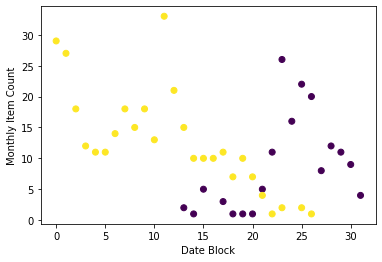

In [34]:
visualize_dupe_pair(9048,9049)

In [35]:
test_dupes = test[test.item_id.isin(items[items.duplicated(['english_name'],keep=False)].item_id)]

In [36]:
test_dupes.item_id.unique()

array([ 5837,  5838, 13804, 13367, 19581, 13387, 13370, 13958, 18719,
       21458,  6027, 19087, 16058, 10750, 13375, 17124,  5063,  9864,
       11199, 10372,  8247, 13390, 18945, 13383, 10749, 12378, 16057,
       11467], dtype=int64)

Via examining the shop names in English, it is clear that a couple of the shops have been duplicated as well. I will address this in the lines below.

In [37]:
train[train.shop_id==58]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
332032,15.03.2013,2,58,8985,349.0,1.0
332033,16.03.2013,2,58,8980,149.0,1.0
332034,11.03.2013,2,58,8965,149.0,1.0
332035,02.03.2013,2,58,8965,149.0,1.0
332036,02.03.2013,2,58,8963,499.0,1.0
...,...,...,...,...,...,...
2901131,03.10.2015,33,58,2035,2499.0,1.0
2901132,05.10.2015,33,58,2039,498.0,1.0
2901133,04.10.2015,33,58,2040,698.0,1.0
2901134,13.10.2015,33,58,2040,698.0,1.0


In [38]:
train[train.shop_id==0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
37589,12.01.2013,0,0,11059,73.0,1.0
37590,22.01.2013,0,0,11059,73.0,1.0
37591,26.01.2013,0,0,11059,73.0,1.0
37592,12.01.2013,0,0,11347,170.0,1.0
37593,22.01.2013,0,0,11347,170.0,1.0
...,...,...,...,...,...,...
183257,22.02.2013,1,0,13460,1228.0,2.0
183258,21.02.2013,1,0,13460,1228.0,1.0
183259,20.02.2013,1,0,13460,1228.0,1.0
183260,17.02.2013,1,0,13460,1228.0,1.0


In [39]:
train['shop_id'] = train['shop_id'].apply(lambda x: 57 if x==0 else x)
train['shop_id'] = train['shop_id'].apply(lambda x: 58 if x==1 else x)

### 2 - Feature Engineering - Preliminary Analysis

In this section, I will explore the data some more, looking for ways to synthesize new features for better predictive performance.

First, I will be comparing the item names in English in order to group them via the brand or series they belong to. This will potentially prove especially useful for new items.

Since we can't use their prior sales data (because there is none), the next best thing will be to use the data of the most similar items to them.

I use a small function called similarity to compare sentences, in this case the English names of the items.

In [40]:
from difflib import SequenceMatcher

In [41]:
def similarity(w1,w2):
    return SequenceMatcher(None,w1,w2).ratio()

In [42]:
items.head()

,item_name,item_id,item_category_id,english_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! in the power of obsession (plast.) d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,! abbyy finereader 12 professional edition ful...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,*** in the rays of glory (unv) d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,*** blue wave (univ) d
4,***КОРОБКА (СТЕКЛО) D,4,40,*** box (glass) d


I add the 'supercategory' feature to the items dataframe, which is just the categories with a slightly more generalized grouping to improve performance.

In [43]:
cat_super_dict = {}

for i,r in cats.iterrows():
    cat_super_dict[r[1]] = r[3]

In [96]:
items['supercat_id'] = items['item_category_id'].apply(lambda x: cat_super_dict[x])

In [97]:
items[items.supercat_id==12]

,item_name,item_id,item_category_id,english_name,supercat_id
1378,"Alan Wake. Коллекционное издание [PC, русские ...",1378,28,"Alan Wake. Collective publication [PC, Russian...",12
1387,"Alien: Isolation. Nostromo Edition [PC, русска...",1387,28,"Alien: ISOLATION. Nostromo Edition [PC, Russia...",12
1406,Aliens: Colonial Marines. Расширенное издание ...,1406,28,Aliens: Colonial Marines. Expanded edition [PC...,12
1430,Anno 2070. Коллекционное издание [PC],1430,28,Anno 2070. Collective publication [PC],12
1437,"Anno 2205. Коллекционное издание [PC, русская ...",1437,28,"Anno 2205. Collective publication [PC, Russian...",12
...,...,...,...,...,...
19254,"Самолеты [PC, русская версия]",19254,28,"Aircraft [PC, Russian version]",12
19406,Снайпер. Воин Призрак 2. Специальное издание [...,19406,28,"Sniper. Warrior Ghost 2. Special edition [PC, ...",12
19934,Тачки 2. Коллекционное издание [PC],19934,28,Cars 2. Collectional publication [PC],12
19935,Тачки 2. Подарочное издание [PC],19935,28,Cars 2. Gift edition [PC],12


I will use regular expressions to filter non-alphanumeric characters and '1c' as shown below.

In [46]:
print(re.sub(r'\W+|1c','','1c: snowball toys "victory day ii. new war"'))

snowballtoysvictorydayiinewwar


The following code detects 'related' items via comparing the first 10 characters of their English names, and considering any pairs with high enough similarity to be related. I then create a dictionary which maps each item to their new group id, which is just the id of the first item encountered which is a part of that group. 

Eg. items 17, 20, and 25 are part of the same group, then the group id will be 17.

In [47]:
supercats = list(range(0,66))

In [ ]:
relations_dict = {}
supercat_count = 0

for supercat in supercats:
    print(f"Supercategory {supercat_count} of {len(supercats)}")
    count = 0
    total = items[items.supercat_id==supercat].shape[0]
    linked = []
    if total < 100:
        vals = items[items.supercat_id==supercat]
        print(vals.index[0])
        #print(vals)
        relations_dict[vals.index[0]] = [row.item_id for ix,row in vals.iloc[1:].iterrows()]
        supercat_count += 1
        continue
    for i,row1 in items[items.supercat_id==supercat].iterrows():
        if count%100 == 0:
            print(f"Step {count} of {total}")
        relations_dict[i] = []
        count += 1
        for j,row2 in items[items.supercat_id==supercat].iterrows():
            if i >= j:
                continue
            if row2.item_id in linked:
                continue
            en1 = re.sub(r'\W+|1c','',row1.english_name)[:10]
            en2 = re.sub(r'\W+|1c','',row2.english_name)[:10]
            if similarity(en1,en2) >= 0.8:
                relations_dict[i].append(row2.item_id)
                linked.append(row2.item_id)
    supercat_count += 1

In [63]:
pkl.dump(relations_dict,open("relations_dict2.pkl", "wb" ))

In [64]:
group_dict = {}
for item in items.item_id:
    if item in relations_dict.keys():
        for val in relations_dict[item]:
            group_dict[val] = item

In [65]:
pkl.dump(group_dict,open("group_dict2.pkl", "wb" ))

Next, I create a dictionary which determines the first sale date of each item.

Both this and the group dictionary will be used to create new features later on.

In [195]:
first_sale_dict = {}
for item in items.item_id:
    if item in train_first.item_id.unique():
        first_sale_dict[item] = train_first[train_first.item_id==item]['date'].values[0]
    else:
        first_sale_dict[item] = 'None'

In [196]:
pkl.dump(first_sale_dict,open("first_sale_dict.pkl", "wb" ))

Since the test data is sales for a particular month, it makes sense to analyze the training data in monthly format.

Here, I group the data and aggregate it via the monthly sum of sales for specific month, shop, and item combinations.

I also create a separate dataframe for the mean monthly prices, in case I want to construct features using price data later on.

In [48]:
train_monthly = train[['date_block_num','shop_id','item_id','item_cnt_day']].groupby(['date_block_num','shop_id','item_id']).sum().reset_index(drop=False)
price_monthly = train[['date_block_num','shop_id','item_id','item_price']].groupby(['date_block_num','shop_id','item_id']).mean().reset_index(drop=False)

In [49]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [50]:
price_monthly.head()

,date_block_num,shop_id,item_id,item_price
0,0,2,27,2499.0
1,0,2,33,499.0
2,0,2,317,299.0
3,0,2,438,299.0
4,0,2,471,399.0


I add the mean price as a column to train_monthly.

In [51]:
train_monthly['item_price'] = price_monthly['item_price']

Now that the data is in monthly form, it is more suitable for visualization.

In [52]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,399.0


First, I will plot the distribution of sales by shop. As can be seen, some shops are a lot more popular thn others, so the shop id will be a significant factor in making predictions.

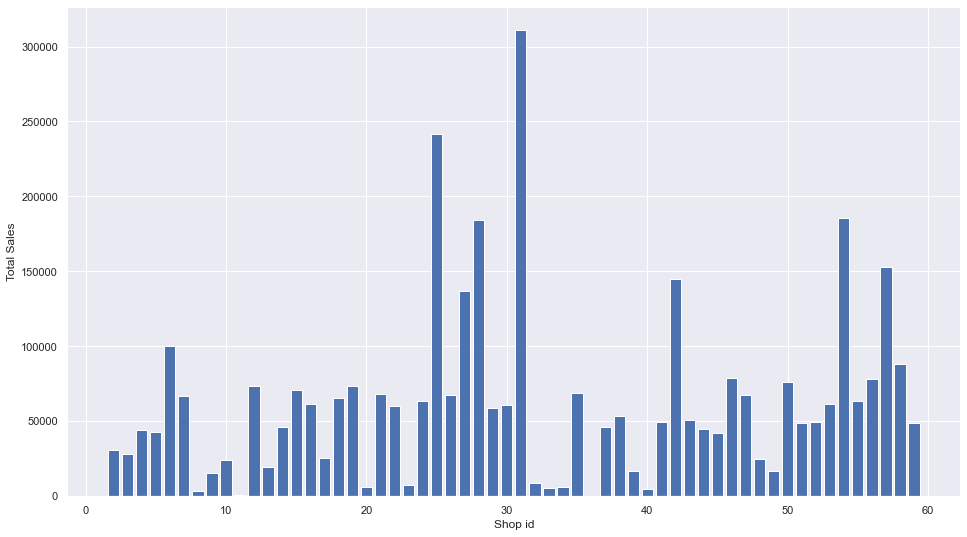

In [53]:
shops_agg = train_monthly[['shop_id','item_cnt_day']].groupby('shop_id').sum()
sns.set()
fig, ax = plt.subplots(figsize =(16, 9))
ax.bar(shops_agg.index,shops_agg.item_cnt_day)
plt.xlabel('Shop id')
plt.ylabel('Total Sales')
plt.show()

In [54]:
largest_shops = shops_agg['item_cnt_day'].nlargest(5)

In [55]:
largest_shops

shop_id
31    310777.0
25    241920.0
54    185790.0
28    184557.0
57    152812.0
Name: item_cnt_day, dtype: float64

In [56]:
train_largest_shops = train_monthly[['date_block_num','shop_id','item_cnt_day']][train_monthly.shop_id.isin(largest_shops.index)].groupby(['date_block_num','shop_id']).sum().reset_index()

In [57]:
import warnings
warnings.filterwarnings("ignore")

shop_1 = pd.DataFrame(columns=['date_block_num','shop_id','item_cnt_day'])
shop_2 = pd.DataFrame(columns=['date_block_num','shop_id','item_cnt_day'])
shop_3 = pd.DataFrame(columns=['date_block_num','shop_id','item_cnt_day'])
shop_4 = pd.DataFrame(columns=['date_block_num','shop_id','item_cnt_day'])
shop_5 = pd.DataFrame(columns=['date_block_num','shop_id','item_cnt_day'])

shops = [shop_1,shop_2,shop_3,shop_4,shop_5]

for i in range(len(shops)):
    for date in train_monthly.date_block_num.unique():
        try:
            item_cnt = train_monthly[['date_block_num','shop_id','item_cnt_day']][train_monthly.shop_id==largest_shops.index[i]][train_monthly.date_block_num==date].groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().values[0]
        
            shops[i] = shops[i].append({'date_block_num':date,'shop_id':largest_shops.index[i],'item_cnt_day':item_cnt},ignore_index=True)
            
        except:
            shops[i] = shops[i].append({'date_block_num':date,'shop_id':largest_shops.index[i],'item_cnt_day':0},ignore_index=True)
    

In [58]:
shops[1]

,date_block_num,shop_id,item_cnt_day
0,0.0,25.0,8215.0
1,1.0,25.0,7934.0
2,2.0,25.0,9732.0
3,3.0,25.0,7867.0
4,4.0,25.0,6860.0
5,5.0,25.0,8478.0
6,6.0,25.0,7361.0
7,7.0,25.0,7784.0
8,8.0,25.0,9251.0
9,9.0,25.0,8356.0


Below is a stacked bar plot of the sales of the five largest shops over the time period (of the training data). As can be seen, some shops remain consistent (outside of seasonality and the overall negative slop of the data) while others either decline or increase sales significantly over the time period. Obtaining  recent lags for the data relating to the shop id is thus important.

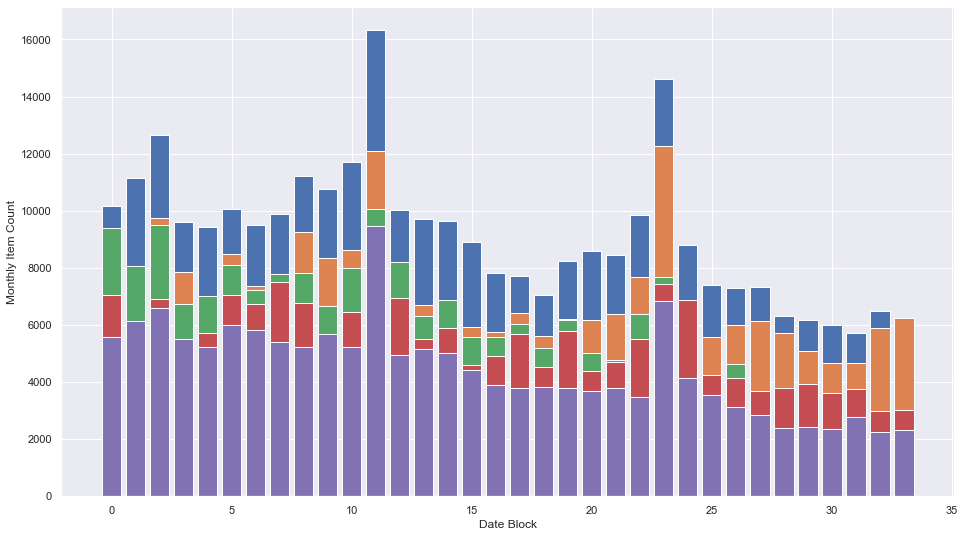

In [59]:
sns.set()

fig,ax = plt.subplots(figsize =(16, 9))

for shop in shops:
    p = plt.bar(shop.date_block_num, shop.item_cnt_day)
    
plt.xlabel('Date Block')
plt.ylabel('Monthly Item Count')
plt.show()


Below, I produced the same plots for supercategories, and a similar conclusion can be drawn. Some supercategories are much more prevalent in sales than others, and individual supercategories often don't follow the general pattern of the data, so recent supercategory lags are also a valuable resource for prediction.

In [20]:
supercat_dict = {}
for i in items.index:
    supercat_dict[items.loc[i,'item_id']] = items.loc[i,'supercat_id']

In [21]:
train_monthly['supercat_id'] = train_monthly['item_id'].apply(lambda x: supercat_dict[x])

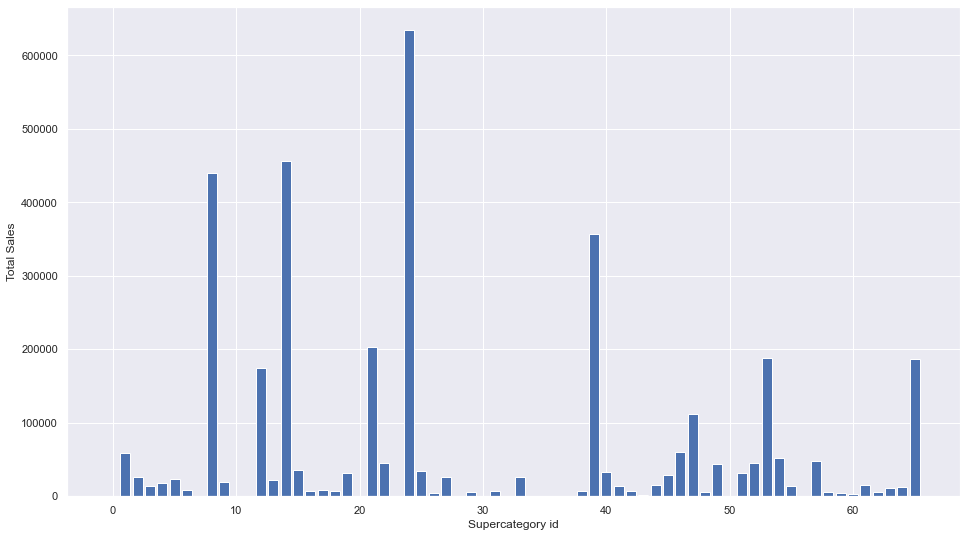

In [23]:
supercat_agg = train_monthly[['supercat_id','item_cnt_day']].groupby('supercat_id').sum()
sns.set()
fig, ax = plt.subplots(figsize =(16, 9))
ax.bar(supercat_agg.index,supercat_agg.item_cnt_day)
plt.xlabel('Supercategory id')
plt.ylabel('Total Sales')
plt.show()

In [25]:
largest_supercats = supercat_agg['item_cnt_day'].nlargest(5)

In [30]:
largest_supercats

supercat_id
24    634171.0
14    456540.0
8     440406.0
39    356872.0
21    203284.0
Name: item_cnt_day, dtype: float64

In [29]:
cats.head(50)

,item_category_name,item_category_id,english,supercategory,megacategory
0,PC - Гарнитуры/Наушники,0,PC - Headsets/Headphones,0,0
1,Аксессуары - PS2,1,Accessories - PS2,1,0
2,Аксессуары - PS3,2,Accessories - PS3,1,0
3,Аксессуары - PS4,3,Accessories - PS4,1,0
4,Аксессуары - PSP,4,Accessories - PSP,1,0
5,Аксессуары - PSVita,5,Accessories - PSVita,1,0
6,Аксессуары - XBOX 360,6,Accessories - XBOX 360,2,0
7,Аксессуары - XBOX ONE,7,Accessories - XBOX ONE,2,0
8,Билеты (Цифра),8,Tickets (Digital),3,1
9,Доставка товара,9,Delivery of goods,4,2


In [26]:
import warnings
warnings.filterwarnings("ignore")

supercat_1 = pd.DataFrame(columns=['date_block_num','supercat_id','item_cnt_day'])
supercat_2 = pd.DataFrame(columns=['date_block_num','supercat_id','item_cnt_day'])
supercat_3 = pd.DataFrame(columns=['date_block_num','supercat_id','item_cnt_day'])
supercat_4 = pd.DataFrame(columns=['date_block_num','supercat_id','item_cnt_day'])
supercat_5 = pd.DataFrame(columns=['date_block_num','supercat_id','item_cnt_day'])

supercats = [supercat_1,supercat_2,supercat_3,supercat_4,supercat_5]

for i in range(len(supercats)):
    for date in train_monthly.date_block_num.unique():
        try:
            item_cnt = train_monthly[['date_block_num','supercat_id','item_cnt_day']][train_monthly.supercat_id==largest_supercats.index[i]][train_monthly.date_block_num==date].groupby(['date_block_num','supercat_id'])['item_cnt_day'].sum().values[0]
        
            supercats[i] = supercats[i].append({'date_block_num':date,'supercats_id':largest_supercats.index[i],'item_cnt_day':item_cnt},ignore_index=True)
            
        except:
            supercats[i] = supercats[i].append({'date_block_num':date,'supercats_id':largest_supercats.index[i],'item_cnt_day':0},ignore_index=True)
    

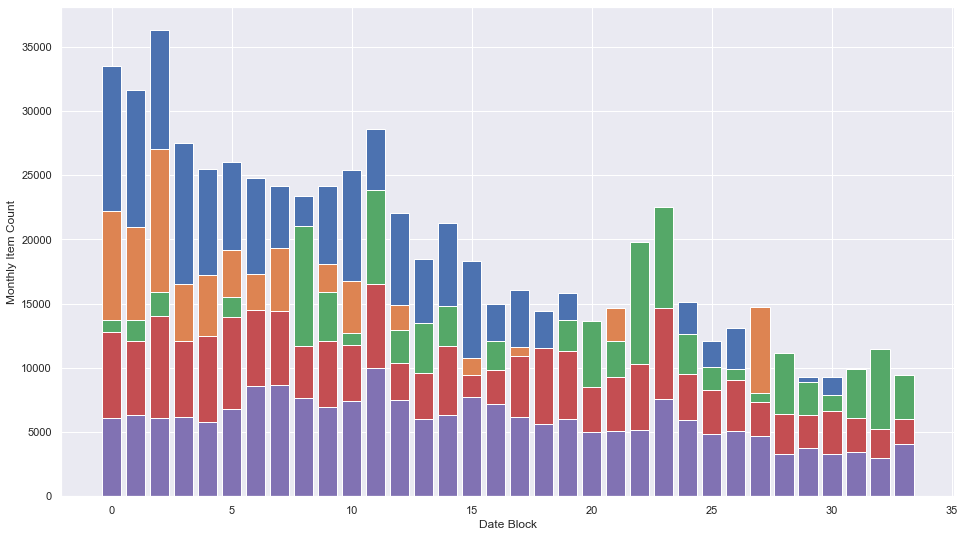

In [27]:
sns.set()

fig,ax = plt.subplots(figsize =(16, 9))

for supercat in supercats:
    p = plt.bar(supercat.date_block_num, supercat.item_cnt_day)
    
plt.xlabel('Date Block')
plt.ylabel('Monthly Item Count')
plt.show()

Here, I augment the data with zero sale values for each shop and item combination that can exist in every date block.

This is an important step. The current data (with very few exceptions) only contains positive sale values, whereas the test data has no such limitation, so the data as it currenly is would amount to a poor predictor. Including the remaining shop/item combinations will make the distribution of each date block in the training set far more similar to the test set.



In [ ]:
monthly_total = pd.DataFrame(columns=train_monthly.columns)

for block in train_monthly.date_block_num.unique():
    df = train_monthly[train_monthly.date_block_num==block]
    shops = pd.DataFrame(df.shop_id.unique(),columns=['shop_id'])
    items = pd.DataFrame(df.item_id.unique(),columns=['item_id'])
    product = shops.assign(dummy=1).merge(items.assign(dummy=1), on='dummy', how='outer').drop('dummy',axis=1)
    df = df.merge(product,how='outer',on=['shop_id','item_id'])
    #df = df.merge(test.loc[:,['shop_id','item_id']],how='outer',on=['shop_id','item_id']).drop_duplicates()
    df['date_block_num'] = block
    print(df.shape)
    monthly_total = monthly_total.append(df)
    print(monthly_total.shape)

The training data ends up having over 10 million rows.

In [61]:
monthly_total.shape

(10913850, 5)

A quick sanity check to make sure none of the block/shop/item combinations are duplicates.

In [62]:
monthly_total[monthly_total.duplicated(['date_block_num','shop_id','item_id'])]

,date_block_num,shop_id,item_id,item_cnt_day,item_price


In [63]:
monthly_total = monthly_total.fillna(0)

In [64]:
len(monthly_total.shop_id.unique())

58

In [65]:
monthly_total.tail()

,date_block_num,shop_id,item_id,item_cnt_day,item_price
238167,33,59,15705,0.0,0.0
238168,33,59,16493,0.0,0.0
238169,33,59,16512,0.0,0.0
238170,33,59,20263,0.0,0.0
238171,33,59,21885,0.0,0.0


In [66]:
monthly_total.to_csv('monthly_total_different.csv')

Here, I created a dictionary of date blocks mapped to the start date of each month. The purpose of this will be to create a first sale feature consisting of the number of days between the first sale of an item and the start of the relevant date block. If the item is new or has yet to be sold, the value will be 0.

In [67]:
date_block_dict = {0:'2013-01-01',1:'2013-02-01',2:'2013-03-01',3:'2013-04-01',4:'2013-05-01',5:'2013-06-01',
                   6:'2013-07-01',7:'2013-08-01',8:'2013-09-01',9:'2013-10-01',10:'2013-11-01',11:'2013-12-01',
                  12:'2014-01-01',13:'2014-02-01',14:'2014-03-01',15:'2014-04-01',16:'2014-05-01',17:'2014-06-01',
                   18:'2014-07-01',19:'2014-08-01',20:'2014-09-01',21:'2014-10-01',22:'2014-11-01',23:'2014-12-01',
                  24:'2015-01-01',25:'2015-02-01',26:'2015-03-01',27:'2015-04-01',28:'2015-05-01',29:'2015-06-01',
                   30:'2015-07-01',31:'2015-08-01',32:'2015-09-01',33:'2015-10-01'}

In [68]:
monthly_total['monthstart'] = monthly_total['date_block_num'].apply(lambda x: date_block_dict[x])

In [69]:
first_sale_dict = pkl.load(open('first_sale_dict.pkl','rb'))

In [ ]:
first_sale_dict

In [71]:
def get_first_sale(x): 
    """
    Calculates the time difference in days between the start of a date block and the first sale of an item.
    
    Inputs: a row x of the monthly training dataframe columns 'item_id' and 'monthstart'.
    
    Returns: The number of days prior to the start of the month that the first sale occurred. If a sale has not
    occurred yet, returns 0.
    """
    
    try:
        val = first_sale_dict[x[0]]
        val = datetime.strptime(val,'%d.%m.%Y').date()
        if x[0] > 22100:    
            print((x[1].date() - val).days)
        if (x[1].date() - val).days > 0:
            return (x[1].date() - val).days
        else:
            return 0
    except:
        return 0

In [72]:
monthly_total['monthstart'] = pd.to_datetime(monthly_total.monthstart)

Here, I create the 'first_sale' feature using the 'get_first_sale' function above and a lambda function.

In [ ]:
monthly_total['first_sale'] = monthly_total[['item_id','monthstart']].apply(lambda x: get_first_sale(x),axis=1)

In [74]:
monthly_total['first_sale'].value_counts()

0       1003487
1         51715
32        45226
2         44781
93        40823
         ...   
911         727
975         704
990         704
943         688
1003        440
Name: first_sale, Length: 1004, dtype: int64

In [75]:
monthly_total.to_csv('monthly_total_different.csv')

I do the same for the test set, and set the date_block_num of the test set to be 34 (one more than the last date_block_num in the train set). I then append the test data to the train data so that I can develop features for them both concurrently.

In [76]:
test['monthstart'] = datetime.strptime('2015-11-01','%Y-%m-%d')

In [ ]:
test['first_sale'] = test[['item_id','monthstart']].apply(lambda x: get_first_sale(x),axis=1)

In [78]:
test.head()

,ID,shop_id,item_id,monthstart,first_sale
0,0,5,5037,2015-11-01,406
1,1,5,5320,2015-11-01,0
2,2,5,5233,2015-11-01,187
3,3,5,5232,2015-11-01,75
4,4,5,5268,2015-11-01,0


In [79]:
test['date_block_num'] = 34

In [80]:
monthly_total['ID'] = -1

In [81]:
monthly_total = monthly_total.append(test[['ID','date_block_num','shop_id','item_id','monthstart','first_sale']])

In [82]:
monthly_total.shape

(11128050, 8)

In [83]:
monthly_total = monthly_total.fillna(0)

In [84]:
monthly_total = monthly_total.reset_index(drop=True)

In [85]:
monthly_total = monthly_total.rename(columns={'item_cnt_day':'y'})

In [86]:
monthly_total.to_csv('monthly_total_with_test_final.csv')

### 3 - Feature Engineering - Creating Lag Features

Now it is time to create the lag features! I will be using lags (backwards monthly time steps) up to 12, so that hopefully the pattern for an entire year will be captured, as there is evident seasonality in the data.

The following code creates some new dataframes and a custom function for the purpose of adding some new lag features relating to the group and/or supercategory id.

The features will be from lags (monthly time steps) 1-12, and will be the monthly sales grouped by the date block, shop id, and group id (or supercategory id) and aggregated by the mean.

In [150]:
monthly_total = pd.read_csv('monthly_total_with_test_final.csv',index_col=0)

In [151]:
monthly_total.head()

,date_block_num,shop_id,item_id,y,item_price,monthstart,first_sale,ID
0,0,2,27,1.0,2499.0,2013-01-01,0,-1
1,0,2,33,1.0,499.0,2013-01-01,0,-1
2,0,2,317,1.0,299.0,2013-01-01,0,-1
3,0,2,438,1.0,299.0,2013-01-01,0,-1
4,0,2,471,2.0,399.0,2013-01-01,0,-1


In [152]:
group_dict = pkl.load(open('group_dict2.pkl','rb'))

In [153]:
items.head()

,item_name,item_id,item_category_id,english_name,supercat_id,group_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! In the power of obsession (plast.) D,24,0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,! Abbyy Finereader 12 Professional Edition Ful...,58,1
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,*** In the rays of glory (unv) D,24,2
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,*** Blue wave (univ) D,24,3
4,***КОРОБКА (СТЕКЛО) D,4,40,*** Box (glass) D,24,4


In [154]:
items['group_id'] = items['item_id'].apply(lambda x: group_dict[x] if x in group_dict.keys() else x)

In [155]:
cat_dict = {}
for i in items.index:
    cat_dict[items.loc[i,'item_id']] = items.loc[i,'item_category_id']

In [156]:
supercat_dict = {}
for i in items.index:
    supercat_dict[items.loc[i,'item_id']] = items.loc[i,'supercat_id']

In [157]:
monthly_total['cat_id'] = monthly_total['item_id'].apply(lambda x: cat_dict[x])

In [158]:
monthly_total['supercat_id'] = monthly_total['item_id'].apply(lambda x: supercat_dict[x])

In [159]:
monthly_total['group_id'] = monthly_total['item_id'].apply(lambda x: group_dict[x] if x in group_dict.keys() else x)

In [160]:
groups_greater_10 = items.group_id.value_counts()[items.group_id.value_counts() >= 10].index

In [161]:
groups_greater_10

Int64Index([  133,   118, 15995,  5074, 14927,  9594,    69,  6515,  6664,
              541,
            ...
            20701, 10888,  9210,  4694,  3710, 21052,  2845,  9214,  8110,
             6001],
           dtype='int64', length=257)

In [162]:
df_temp_1 = monthly_total[monthly_total.first_sale < 30]
df_temp_3 = monthly_total[(monthly_total.first_sale > 30) & (monthly_total.first_sale <= 90)]
df_temp_6 = monthly_total[(monthly_total.first_sale > 90) & (monthly_total.first_sale <= 180)]
df_temp_rest = monthly_total[monthly_total.first_sale > 180]

In [163]:
df_temp_group_1 = df_temp_1[['date_block_num','shop_id','group_id','y']].groupby(['date_block_num','shop_id','group_id']).mean()
df_temp_group_3 = df_temp_3[['date_block_num','shop_id','group_id','y']].groupby(['date_block_num','shop_id','group_id']).mean()
df_temp_group_6 = df_temp_6[['date_block_num','shop_id','group_id','y']].groupby(['date_block_num','shop_id','group_id']).mean()
df_temp_group_rest = df_temp_rest[['date_block_num','shop_id','group_id','y']].groupby(['date_block_num','shop_id','group_id']).mean()

df_temp_supercat_1 = df_temp_1[['date_block_num','shop_id','supercat_id','y']].groupby(['date_block_num','shop_id','supercat_id']).mean()
df_temp_supercat_3 = df_temp_3[['date_block_num','shop_id','supercat_id','y']].groupby(['date_block_num','shop_id','supercat_id']).mean()
df_temp_supercat_6 = df_temp_6[['date_block_num','shop_id','supercat_id','y']].groupby(['date_block_num','shop_id','supercat_id']).mean()
df_temp_supercat_rest = df_temp_rest[['date_block_num','shop_id','supercat_id','y']].groupby(['date_block_num','shop_id','supercat_id']).mean()

In [164]:
def get_group_neighbors(x,lag=1):
    """
    Calculates the average num_sales of new (<15 days old) items in the same group as the input item for a previous lag.
    Inputs: a row of the monthly total dataframe, the number of monthly lags.
    Returns: the average sales number of new items for a prior lag if the input item is also new, else 0.
    """
    
    global count
    count += 1
    if count%100000 == 0:
        print(count) 
    try:
        if x[4] > 15:
            return 0
        else:
            if x[2] in groups_greater_10:
                val = df_temp_group_1.loc[(x[0]-lag,x[1],x[2]),'y']
                if val != 0:
                    return val
                else:
                    return df_temp_supercat_1.loc[(x[0]-lag,x[1],x[3]),'y']
            else:
                return df_temp_supercat_1.loc[(x[0]-lag,x[1],x[3]),'y']    
    except:
        return 0

In [ ]:
count = 0
for lag in range(1,13):
    monthly_total['group_neighbors_lag_'+str(lag)] = monthly_total[['date_block_num','shop_id','group_id','supercat_id','first_sale']].apply(lambda x: get_group_neighbors(x,lag),axis=1)

In [166]:
def get_all_neighbors(x,lag=1):
    
    """
    Calculates the average num_sales of items in the same group as the input item split into categories by item age,
    for a previous lag.
    Inputs: a row of the monthly total dataframe, the number of monthly lags.
    Returns: the average sales number of items in the same group and age category as the input item for a previous lag.
    """
    
    global count
    count += 1
    if count%10000 == 0:
        print(count)
    try:
        if x[4] <= 15:
            if x[2] in groups_greater_10:
                val = df_temp_group_1.loc[(x[0]-lag,x[1],x[2]),'y']
                if val != 0:
                    return val
                else:
                    return df_temp_supercat_1.loc[(x[0]-lag,x[1],x[3]),'y']
            else:
                return df_temp_supercat_1.loc[(x[0]-lag,x[1],x[3]),'y']
        elif x[3] < 90:
            if x[2] in groups_greater_10:
                val = df_temp_group_3.loc[(x[0]-lag,x[1],x[2]),'y']
                if val != 0:
                    return val
                else:
                    return df_temp_supercat_3.loc[(x[0]-lag,x[1],x[3]),'y']
            else:
                return df_temp_supercat_3.loc[(x[0]-lag,x[1],x[3]),'y']
        elif x[3] < 180:
            if x[2] in groups_greater_10:
                val = df_temp_group_6.loc[(x[0]-lag,x[1],x[2]),'y']
                if val != 0:
                    return val
                else:
                    return df_temp_supercat_6.loc[(x[0]-lag,x[1],x[3]),'y']
            else:
                return df_temp_supercat_6.loc[(x[0]-lag,x[1],x[3]),'y']
        else:
            if x[2] in groups_greater_10:
                val = df_temp_group_rest.loc[(x[0]-lag,x[1],x[2]),'y']
                if val != 0:
                    return val
                else:
                    return df_temp_supercat_rest.loc[(x[0]-lag,x[1],x[3]),'y']
            else:
                return df_temp_supercat_rest.loc[(x[0]-lag,x[1],x[3]),'y']
    except:
        return 0

In [ ]:
count = 0
for lag in range(1,13):
    monthly_total['group_all_neighbors_lag_'+str(lag)] = monthly_total[['date_block_num','shop_id','group_id','supercat_id','first_sale']].apply(lambda x: get_all_neighbors(x,lag),axis=1)

In [280]:
monthly_total.to_csv('monthly_total_with_test_final.csv')

Here, I calculate the lags for the sales of the input item for previous time steps (months), via creating a new dataframe and using a custom function.

In [168]:
monthly_total_index = monthly_total.set_index(keys=['date_block_num','shop_id','item_id'])

In [169]:
def get_lags(x,lag=1):
    
    """
    Calculates the num_sales of the input item at the input shop id for a previous lag.
    Inputs: a row of the monthly_total dataframe, the number of monthly lags.
    Returns: the num_sales of as the input item at the input shop for a previous lag.
    """
    
    global count
    count += 1
    if count%100000 == 0:
        print(count)
    try:
        val = monthly_total_index.loc[(x[0]-lag,x[1],x[2]),'y']
        return val
    except:
        return 0

In [ ]:
count = 0
for lag in range(1,13):
    print(lag)
    monthly_total['lag_'+str(lag)] = monthly_total[['date_block_num','shop_id','item_id']].apply(lambda x: get_lags(x,lag),axis=1)

In [171]:
monthly_total.to_csv('monthly_total_with_test_lags.csv')

Here, I get the lags for the mean sales of items irrespective of the shop they were at, ie. the mean item sales for each month.

In [172]:
def get_item_lags(x,lag=1):
    global count
    count += 1
    if count%100000 == 0:
        print(count)
    try:
        val = monthly_total_index.loc[(x[0]-lag,x[1]),'y']
        return val
    except:
        return 0

In [173]:
monthly_total_index = monthly_total[['date_block_num','item_id','y']].groupby(['date_block_num','item_id']).mean()

In [ ]:
count = 0
for lag in range(1,13):
    print(lag)
    monthly_total['item_mean_lag_'+str(lag)] = monthly_total[['date_block_num','item_id']].apply(lambda x: get_item_lags(x,lag),axis=1)

Here, I get the lags for the total shop sales of all items for each month.

In [175]:
def get_shop_lags(x,lag=1):
    global count
    count += 1
    if count%100000 == 0:
        print(count)
    try:
        val = monthly_total_index.loc[(x[0]-lag,x[1]),'y']
        return val
    except:
        return 0

In [176]:
monthly_total_index = monthly_total[['date_block_num','shop_id','y']].groupby(['date_block_num','shop_id']).sum()

In [ ]:
count = 0
for lag in range(1,13):
    print(lag)
    monthly_total['shop_sum_lag_'+str(lag)] = monthly_total[['date_block_num','shop_id']].apply(lambda x: get_shop_lags(x,lag),axis=1)

In [178]:
monthly_total.to_csv('monthly_total_with_test_lags_final.csv')

Here, I create some additional features by combining the currently engineered features.

Specifically, I create features for the average values of lags over 6 month periods and 12 month periods, and then remove the individual monthly lags > 3. I believe this will provide the most relevant features for accurate predictions.

In [179]:
monthly_total = pd.read_csv('monthly_total_with_test_lags_final.csv',index_col=0)

In [180]:
monthly_total['lag_1_6'] = (monthly_total['lag_1'] + monthly_total['lag_2'] + monthly_total['lag_3'] + monthly_total['lag_4'] + monthly_total['lag_5'] + monthly_total['lag_6'])/6
monthly_total['lag_1_12'] = (monthly_total['lag_1'] + monthly_total['lag_2'] + monthly_total['lag_3'] + monthly_total['lag_4'] + monthly_total['lag_5'] + monthly_total['lag_6'] +
                           monthly_total['lag_7'] + monthly_total['lag_8'] + monthly_total['lag_9'] + monthly_total['lag_10'] + monthly_total['lag_11'] + monthly_total['lag_12'])/12
monthly_total = monthly_total.drop(['lag_4','lag_5','lag_6','lag_7','lag_8','lag_9','lag_10','lag_11'],axis=1)
monthly_total['group_all_neighbors_lag_1_6'] = (monthly_total['group_all_neighbors_lag_1'] + monthly_total['group_all_neighbors_lag_2'] + monthly_total['group_all_neighbors_lag_3'] + monthly_total['group_all_neighbors_lag_4'] + monthly_total['group_all_neighbors_lag_5'] + monthly_total['group_all_neighbors_lag_6'])/6
monthly_total['group_all_neighbors_lag_1_12'] = (monthly_total['group_all_neighbors_lag_1'] + monthly_total['group_all_neighbors_lag_2'] + monthly_total['group_all_neighbors_lag_3'] + monthly_total['group_all_neighbors_lag_4'] + monthly_total['group_all_neighbors_lag_5'] + monthly_total['group_all_neighbors_lag_6'] +
                                               monthly_total['group_all_neighbors_lag_7'] + monthly_total['group_all_neighbors_lag_8'] + monthly_total['group_all_neighbors_lag_9'] + monthly_total['group_all_neighbors_lag_10'] + monthly_total['group_all_neighbors_lag_11'] + monthly_total['group_all_neighbors_lag_12'])/12
monthly_total = monthly_total.drop(['group_all_neighbors_lag_4','group_all_neighbors_lag_5','group_all_neighbors_lag_6','group_all_neighbors_lag_7','group_all_neighbors_lag_8','group_all_neighbors_lag_9','group_all_neighbors_lag_10','group_all_neighbors_lag_11'],axis=1)

monthly_total['item_mean_lag_1_6'] = (monthly_total['item_mean_lag_1'] + monthly_total['item_mean_lag_2'] + monthly_total['item_mean_lag_3'] + monthly_total['item_mean_lag_4'] + monthly_total['item_mean_lag_5'] + monthly_total['item_mean_lag_6'])/6
monthly_total['item_mean_lag_1_12'] = (monthly_total['item_mean_lag_1'] + monthly_total['item_mean_lag_2'] + monthly_total['item_mean_lag_3'] + monthly_total['item_mean_lag_4'] + monthly_total['item_mean_lag_5'] + monthly_total['item_mean_lag_6'] +
                                     monthly_total['item_mean_lag_7'] + monthly_total['item_mean_lag_8'] + monthly_total['item_mean_lag_9'] + monthly_total['item_mean_lag_10'] + monthly_total['item_mean_lag_11'] + monthly_total['item_mean_lag_12'])/12
monthly_total = monthly_total.drop(['item_mean_lag_4','item_mean_lag_5','item_mean_lag_6','item_mean_lag_7','item_mean_lag_8','item_mean_lag_9','item_mean_lag_10','item_mean_lag_11'],axis=1)

monthly_total['shop_sum_lag_1_6'] = (monthly_total['shop_sum_lag_1'] + monthly_total['shop_sum_lag_2'] + monthly_total['shop_sum_lag_3'] + monthly_total['shop_sum_lag_4'] + monthly_total['shop_sum_lag_5'] + monthly_total['shop_sum_lag_6'])/6
monthly_total['shop_sum_lag_1_12'] = (monthly_total['shop_sum_lag_1'] + monthly_total['shop_sum_lag_2'] + monthly_total['shop_sum_lag_3'] + monthly_total['shop_sum_lag_4'] + monthly_total['shop_sum_lag_5'] + monthly_total['shop_sum_lag_6'] +
                                    monthly_total['shop_sum_lag_7'] + monthly_total['shop_sum_lag_8'] + monthly_total['shop_sum_lag_9'] + monthly_total['shop_sum_lag_10'] + monthly_total['shop_sum_lag_11'] + monthly_total['shop_sum_lag_12'])/12

monthly_total = monthly_total.drop(['shop_sum_lag_4','shop_sum_lag_5','shop_sum_lag_6','shop_sum_lag_7','shop_sum_lag_8','shop_sum_lag_9','shop_sum_lag_10','shop_sum_lag_11'],axis=1)

In [181]:
monthly_total['group_neighbors_lag_1_6'] = (monthly_total['group_neighbors_lag_1'] + monthly_total['group_neighbors_lag_2'] + monthly_total['group_neighbors_lag_3'] + monthly_total['group_neighbors_lag_4'] + monthly_total['group_neighbors_lag_5'] + monthly_total['group_neighbors_lag_6'])/6
monthly_total['group_neighbors_lag_1_12'] = (monthly_total['group_neighbors_lag_1'] + monthly_total['group_neighbors_lag_2'] + monthly_total['group_neighbors_lag_3'] + monthly_total['group_neighbors_lag_4'] + monthly_total['group_neighbors_lag_5'] + monthly_total['group_neighbors_lag_6'] +
                                               monthly_total['group_neighbors_lag_7'] + monthly_total['group_neighbors_lag_8'] + monthly_total['group_neighbors_lag_9'] + monthly_total['group_neighbors_lag_10'] + monthly_total['group_neighbors_lag_11'] + monthly_total['group_neighbors_lag_12'])/12
monthly_total = monthly_total.drop(['group_neighbors_lag_4','group_neighbors_lag_5','group_neighbors_lag_6','group_neighbors_lag_7','group_neighbors_lag_8','group_neighbors_lag_9','group_neighbors_lag_10','group_neighbors_lag_11'],axis=1)

In [184]:
monthly_total.tail(50)

,date_block_num,shop_id,item_id,y,item_price,monthstart,first_sale,ID,cat_id,supercat_id,...,lag_1_6,lag_1_12,group_all_neighbors_lag_1_6,group_all_neighbors_lag_1_12,item_mean_lag_1_6,item_mean_lag_1_12,shop_sum_lag_1_6,shop_sum_lag_1_12,group_neighbors_lag_1_6,group_neighbors_lag_1_12
11128000,34,45,7572,0.0,0.0,2015-11-01,0,214150,64,47,...,0.000000,0.000000,0.249346,0.228197,0.000000,0.000000,687.5,858.75,0.249346,0.228197
11128001,34,45,7925,0.0,0.0,2015-11-01,366,214151,7,2,...,0.166667,0.250000,0.000000,0.081481,0.034712,0.379300,687.5,858.75,0.000000,0.000000
11128002,34,45,6117,0.0,0.0,2015-11-01,501,214152,30,14,...,0.000000,0.250000,1.072222,1.136911,0.151024,0.370042,687.5,858.75,0.000000,0.000000
11128003,34,45,6108,0.0,0.0,2015-11-01,866,214153,30,14,...,0.166667,0.250000,1.072222,1.136911,0.304956,0.377928,687.5,858.75,0.000000,0.000000
11128004,34,45,9030,0.0,0.0,2015-11-01,0,214154,40,24,...,0.000000,0.000000,0.286823,0.324067,0.000000,0.000000,687.5,858.75,0.286823,0.324067
11128005,34,45,21425,0.0,0.0,2015-11-01,1020,214155,38,22,...,0.000000,0.000000,0.333333,0.226852,0.011628,0.028051,687.5,858.75,0.000000,0.000000
11128006,34,45,3316,0.0,0.0,2015-11-01,1033,214156,19,8,...,0.000000,0.250000,0.000000,0.833333,0.023445,0.185110,687.5,858.75,0.000000,0.000000
11128007,34,45,19024,0.0,0.0,2015-11-01,554,214157,37,21,...,0.000000,0.000000,0.167250,0.266200,0.069788,0.060938,687.5,858.75,0.000000,0.000000
11128008,34,45,6156,0.0,0.0,2015-11-01,1034,214158,30,14,...,0.166667,0.250000,1.072222,1.136911,0.245705,0.342846,687.5,858.75,0.000000,0.000000
11128009,34,45,7972,0.0,0.0,2015-11-01,650,214159,33,17,...,0.000000,0.000000,0.666667,0.500000,0.096564,0.218254,687.5,858.75,0.000000,0.000000


In [186]:
monthly_total.to_csv('monthly_total_final_features.csv')

In [187]:
monthly_total.columns

Index(['date_block_num', 'shop_id', 'item_id', 'y', 'item_price', 'monthstart',
       'first_sale', 'ID', 'cat_id', 'supercat_id', 'group_id',
       'group_neighbors_lag_1', 'group_neighbors_lag_2',
       'group_neighbors_lag_3', 'group_neighbors_lag_12',
       'group_all_neighbors_lag_1', 'group_all_neighbors_lag_2',
       'group_all_neighbors_lag_3', 'group_all_neighbors_lag_12', 'lag_1',
       'lag_2', 'lag_3', 'lag_12', 'item_mean_lag_1', 'item_mean_lag_2',
       'item_mean_lag_3', 'item_mean_lag_12', 'shop_sum_lag_1',
       'shop_sum_lag_2', 'shop_sum_lag_3', 'shop_sum_lag_12', 'lag_1_6',
       'lag_1_12', 'group_all_neighbors_lag_1_6',
       'group_all_neighbors_lag_1_12', 'item_mean_lag_1_6',
       'item_mean_lag_1_12', 'shop_sum_lag_1_6', 'shop_sum_lag_1_12',
       'group_neighbors_lag_1_6', 'group_neighbors_lag_1_12'],
      dtype='object')

In [188]:
monthly_total['month'] = monthly_total['date_block_num'].apply(lambda x: (x%12)+1)

In [189]:
monthly_total.to_csv('monthly_total_adjusted.csv')

In [190]:
monthly_total = pd.read_csv('monthly_total_adjusted.csv',index_col=0)

In [191]:
monthly_total.columns

Index(['date_block_num', 'shop_id', 'item_id', 'y', 'item_price', 'monthstart',
       'first_sale', 'ID', 'cat_id', 'supercat_id', 'group_id',
       'group_neighbors_lag_1', 'group_neighbors_lag_2',
       'group_neighbors_lag_3', 'group_neighbors_lag_12',
       'group_all_neighbors_lag_1', 'group_all_neighbors_lag_2',
       'group_all_neighbors_lag_3', 'group_all_neighbors_lag_12', 'lag_1',
       'lag_2', 'lag_3', 'lag_12', 'item_mean_lag_1', 'item_mean_lag_2',
       'item_mean_lag_3', 'item_mean_lag_12', 'shop_sum_lag_1',
       'shop_sum_lag_2', 'shop_sum_lag_3', 'shop_sum_lag_12', 'lag_1_6',
       'lag_1_12', 'group_all_neighbors_lag_1_6',
       'group_all_neighbors_lag_1_12', 'item_mean_lag_1_6',
       'item_mean_lag_1_12', 'shop_sum_lag_1_6', 'shop_sum_lag_1_12',
       'group_neighbors_lag_1_6', 'group_neighbors_lag_1_12', 'month'],
      dtype='object')

Finally, I will cluster the item shops according to the types of items they sell, and generate lag features from the shop clusters.

In [193]:
monthly_total_shops = monthly_total[monthly_total.date_block_num != 34][['shop_id','supercat_id','y']].groupby(['shop_id','supercat_id']).sum()

In [194]:
monthly_total_shops = monthly_total_shops.reset_index().pivot(index='shop_id',columns='supercat_id',values='y')

In [195]:
monthly_total_shops = monthly_total_shops.fillna(0)

In [196]:
monthly_total_shops

supercat_id,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
shop_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,974.0,405.0,4.0,0.0,408.0,118.0,8.0,7957.0,204.0,...,0.0,512.0,0.0,36.0,0.0,222.0,0.0,72.0,51.0,3189.0
3,0.0,695.0,317.0,100.0,0.0,209.0,58.0,1.0,5011.0,122.0,...,0.0,156.0,0.0,13.0,0.0,252.0,99.0,0.0,56.0,2523.0
4,0.0,899.0,383.0,6.0,0.0,344.0,142.0,8.0,5375.0,267.0,...,0.0,781.0,0.0,106.0,0.0,501.0,5.0,411.0,70.0,2986.0
5,0.0,705.0,279.0,39.0,0.0,299.0,114.0,8.0,5437.0,223.0,...,0.0,123.0,0.0,12.0,0.0,309.0,26.0,0.0,120.0,2247.0
6,0.0,1371.0,484.0,56.0,0.0,708.0,164.0,3.0,11898.0,357.0,...,0.0,1653.0,0.0,184.0,0.0,639.0,62.0,660.0,693.0,4185.0
7,0.0,1346.0,526.0,19.0,0.0,604.0,239.0,17.0,9914.0,461.0,...,0.0,936.0,0.0,18.0,0.0,689.0,25.0,0.0,145.0,4762.0
8,0.0,28.0,12.0,0.0,0.0,7.0,7.0,0.0,408.0,19.0,...,0.0,39.0,0.0,21.0,0.0,1.0,0.0,0.0,0.0,114.0
9,0.0,103.0,84.0,0.0,0.0,29.0,16.0,0.0,1473.0,28.0,...,0.0,194.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,758.0
10,0.0,395.0,180.0,0.0,0.0,163.0,53.0,0.0,3204.0,30.0,...,0.0,1042.0,0.0,9.0,0.0,0.0,0.0,208.0,134.0,1203.0


In [197]:
scaler = StandardScaler()
monthly_total_shops_scaled = scaler.fit_transform(monthly_total_shops.T).T

In [198]:
monthly_total_shops_scaled = pd.DataFrame(columns=monthly_total_shops.columns,index=monthly_total_shops.index,data=monthly_total_shops_scaled)

In [199]:
monthly_total_shops_scaled

supercat_id,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
shop_id,,,,,,,,,,,,,,,,,,,,,
2,-0.381239,0.419138,-0.048433,-0.377952,-0.381239,-0.045968,-0.284273,-0.374665,6.157365,-0.213603,...,-0.381239,0.039493,-0.381239,-0.351656,-0.381239,-0.198812,-0.381239,-0.322073,-0.339330,2.239297
3,-0.410672,0.253674,-0.107654,-0.315083,-0.410672,-0.210890,-0.355230,-0.409716,4.379308,-0.294053,...,-0.410672,-0.261553,-0.410672,-0.398245,-0.410672,-0.169787,-0.316039,-0.410672,-0.357142,2.001046
4,-0.419818,0.147054,-0.178314,-0.416034,-0.419818,-0.202906,-0.330279,-0.414773,2.969431,-0.251459,...,-0.419818,0.072648,-0.419818,-0.352979,-0.419818,-0.103908,-0.416665,-0.160659,-0.375679,1.463028
5,-0.416485,0.036699,-0.237140,-0.391415,-0.416485,-0.224284,-0.343204,-0.411342,3.078494,-0.273137,...,-0.416485,-0.337419,-0.416485,-0.408771,-0.416485,-0.217855,-0.399772,-0.416485,-0.339347,1.027918
6,-0.468656,-0.046652,-0.319677,-0.451419,-0.468656,-0.250728,-0.418176,-0.467733,3.193642,-0.358769,...,-0.468656,0.040150,-0.468656,-0.412019,-0.468656,-0.271967,-0.449572,-0.265503,-0.255345,0.819520
7,-0.427451,0.138821,-0.206159,-0.419458,-0.427451,-0.173344,-0.326902,-0.420299,3.743440,-0.233505,...,-0.427451,-0.033669,-0.427451,-0.419879,-0.427451,-0.137584,-0.416934,-0.427451,-0.366449,1.575956
8,-0.374671,-0.182072,-0.292129,-0.374671,-0.374671,-0.326521,-0.326521,-0.374671,2.431766,-0.243979,...,-0.374671,-0.106409,-0.374671,-0.230222,-0.374671,-0.367792,-0.374671,-0.374671,-0.374671,0.409480
9,-0.378882,-0.216545,-0.246491,-0.378882,-0.378882,-0.333175,-0.353665,-0.378882,1.942696,-0.334752,...,-0.378882,-0.073121,-0.378882,-0.378882,-0.378882,-0.356817,-0.378882,-0.378882,-0.378882,0.815793
10,-0.426832,0.026926,-0.220056,-0.426832,-0.426832,-0.239585,-0.365948,-0.426832,3.253780,-0.392370,...,-0.426832,0.770171,-0.426832,-0.416493,-0.426832,-0.426832,-0.426832,-0.187891,-0.272899,0.955120


Here, I calculate the K means clusters for K between 3 and 20, and plot the amount of distortion associated with each cluster. Distortion will always decrease with increasing K, so the accepted method of picking the correct K is the point at which the distortion stops decreasing so sharply, the 'elbow' method. According to this principle, 10 seems to be a suitable value for K.

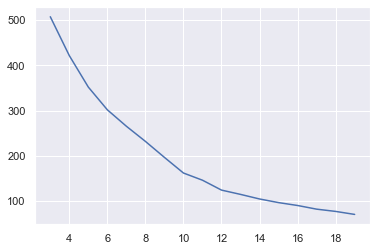

In [200]:
distortion_list = []
sizes = range(3,20)

for K in sizes:
    kmc = KMeans(n_clusters=K, random_state=42).fit(monthly_total_shops_scaled)
    distortion_list.append(kmc.inertia_)
    
plt.plot(sizes,distortion_list)
    

In [201]:
kmcfinal = KMeans(n_clusters=10, random_state=42).fit(monthly_total_shops_scaled)
print(kmcfinal.labels_)

[0 1 1 1 1 1 1 9 1 1 7 2 5 1 1 5 0 1 4 2 8 1 1 2 1 5 2 1 2 2 1 5 0 5 5 5 0
 5 6 1 5 0 2 1 1 0 5 5 1 2 1 5 2 3 2 2 2 1]


Here, I map the shop ids to their respective clusters, then create a temporary DataFrame as before to generate the lag features relating to the clusters.

In [202]:
labeldict = {}
for i in range(len(monthly_total_shops.index)):
    labeldict[monthly_total_shops.index[i]] = kmcfinal.labels_[i]
    
monthly_total['shop_cluster'] = monthly_total['shop_id'].apply(lambda x: labeldict[x])

In [203]:
monthly_total.head()

,date_block_num,shop_id,item_id,y,item_price,monthstart,first_sale,ID,cat_id,supercat_id,...,group_all_neighbors_lag_1_6,group_all_neighbors_lag_1_12,item_mean_lag_1_6,item_mean_lag_1_12,shop_sum_lag_1_6,shop_sum_lag_1_12,group_neighbors_lag_1_6,group_neighbors_lag_1_12,month,shop_cluster
0,0,2,27,1.0,2499.0,2013-01-01,0,-1,19,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,0,2,33,1.0,499.0,2013-01-01,0,-1,37,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0,2,317,1.0,299.0,2013-01-01,0,-1,45,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,0,2,438,1.0,299.0,2013-01-01,0,-1,45,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,0,2,471,2.0,399.0,2013-01-01,0,-1,49,33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [204]:
monthly_total[monthly_total.date_block_num!=34].shop_cluster.unique()

array([0, 1, 7, 2, 5, 8, 3, 9, 6, 4])

In [205]:
monthly_total[monthly_total.date_block_num==34].shop_cluster.unique()

array([1, 0, 7, 2, 8, 5, 3])

In [206]:
df_temp_1 = monthly_total[monthly_total.first_sale < 30]
df_temp_group_1 = df_temp_1[['date_block_num','shop_cluster','group_id','y']].groupby(['date_block_num','shop_cluster','group_id']).mean()
df_temp_supercat_1 = df_temp_1[['date_block_num','shop_cluster','supercat_id','y']].groupby(['date_block_num','shop_cluster','supercat_id']).mean()

In [ ]:
count = 0
for lag in range(1,13):
    monthly_total['group_neighbors_cluster_lag_'+str(lag)] = monthly_total[['date_block_num','shop_cluster','group_id','supercat_id','first_sale']].apply(lambda x: get_group_neighbors(x,lag),axis=1)

I create some additional features from the shop cluster features as before.

In [208]:
monthly_total['group_neighbors_cluster_lag_1_6'] = (monthly_total['group_neighbors_cluster_lag_1'] + monthly_total['group_neighbors_cluster_lag_2'] + monthly_total['group_neighbors_cluster_lag_3'] + monthly_total['group_neighbors_cluster_lag_4'] + monthly_total['group_neighbors_cluster_lag_5'] + monthly_total['group_neighbors_cluster_lag_6'])/6
monthly_total['group_neighbors_cluster_lag_1_12'] = (monthly_total['group_neighbors_cluster_lag_1'] + monthly_total['group_neighbors_cluster_lag_2'] + monthly_total['group_neighbors_cluster_lag_3'] + monthly_total['group_neighbors_cluster_lag_4'] + monthly_total['group_neighbors_cluster_lag_5'] + monthly_total['group_neighbors_cluster_lag_6'] +
                                               monthly_total['group_neighbors_cluster_lag_7'] + monthly_total['group_neighbors_cluster_lag_8'] + monthly_total['group_neighbors_cluster_lag_9'] + monthly_total['group_neighbors_cluster_lag_10'] + monthly_total['group_neighbors_cluster_lag_11'] + monthly_total['group_neighbors_cluster_lag_12'])/12

monthly_total = monthly_total.drop(['group_neighbors_cluster_lag_4','group_neighbors_cluster_lag_5','group_neighbors_cluster_lag_6','group_neighbors_cluster_lag_7','group_neighbors_cluster_lag_8','group_neighbors_cluster_lag_9','group_neighbors_cluster_lag_10','group_neighbors_cluster_lag_11'],axis=1)

In [209]:
monthly_total.to_csv('monthly_total_all_final_features.csv')

In [2]:
monthly_total = pd.read_csv('monthly_total_all_final_features.csv',index_col=0)

In [3]:
monthly_total.columns

Index(['date_block_num', 'shop_id', 'item_id', 'y', 'item_price', 'monthstart',
       'first_sale', 'ID', 'cat_id', 'supercat_id', 'group_id',
       'group_neighbors_lag_1', 'group_neighbors_lag_2',
       'group_neighbors_lag_3', 'group_neighbors_lag_12',
       'group_all_neighbors_lag_1', 'group_all_neighbors_lag_2',
       'group_all_neighbors_lag_3', 'group_all_neighbors_lag_12', 'lag_1',
       'lag_2', 'lag_3', 'lag_12', 'item_mean_lag_1', 'item_mean_lag_2',
       'item_mean_lag_3', 'item_mean_lag_12', 'shop_sum_lag_1',
       'shop_sum_lag_2', 'shop_sum_lag_3', 'shop_sum_lag_12', 'lag_1_6',
       'lag_1_12', 'group_all_neighbors_lag_1_6',
       'group_all_neighbors_lag_1_12', 'item_mean_lag_1_6',
       'item_mean_lag_1_12', 'shop_sum_lag_1_6', 'shop_sum_lag_1_12',
       'group_neighbors_lag_1_6', 'group_neighbors_lag_1_12', 'month',
       'shop_cluster', 'group_neighbors_cluster_lag_1',
       'group_neighbors_cluster_lag_2', 'group_neighbors_cluster_lag_3',
       'gro

### 4 - Modeling

With all the lag features prepared, it's now time to model the data, attempting to get the lowest validation score as possible, before applying the final model to the test data.

First I separate the data for training and validation. Since this is time series data, I will use the penultimate time step (the one before the step we wish to predict) to validate.

In [4]:
monthly_total_tr = monthly_total[~monthly_total['date_block_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11,33,34])]
monthly_total_val = monthly_total[monthly_total['date_block_num'] == 33]
#monthly_total_test = monthly_total[monthly_total['date_block_num'] == 34]

In [5]:
X_tr = monthly_total_tr.drop(['y','ID','monthstart','item_price'],axis=1)
y_tr = monthly_total_tr['y']

X_val = monthly_total_val.drop(['y','ID','monthstart','item_price'],axis=1)
y_val = monthly_total_val['y']

The challenge relating to this project clips the values to a maximum of 20, so I will do the same.

In [6]:
y_tr = y_tr.apply(lambda x: 20 if x > 20 else x)
y_val = y_val.apply(lambda x: 20 if x > 20 else x)

I will use CatBoostRegressor to make my prediction, as I know that it performs well on these types of problems. I will perform a grid search using the parameters below, and print the result for each combination.

In [ ]:
cb_params = {
    'max_depth': [5,6,8],
    'learning_rate': [0.025,0.05],
}

In [17]:
for depth in [5,6,8]:
    for lr in [0.025,0.05]:
        cb = CatBoostRegressor(iterations=500,max_depth=depth,learning_rate=lr,l2_leaf_reg=0,random_seed=42,verbose=0,od_wait=50)
        cb.fit(X_tr,y_tr,eval_set=(X_val, y_val))
        print(f"Depth: {depth}, Learning Rate: {lr}, Best Iteration: {cb.get_best_iteration()}, Best Score: {cb.get_best_score()}")

Depth: 5, Learning Rate: 0.025,Best Iteration: 499, Best Score: {'learn': {'RMSE': 0.8252033299732694}, 'validation': {'RMSE': 0.8932203316657018}}
Depth: 5, Learning Rate: 0.05,Best Iteration: 499, Best Score: {'learn': {'RMSE': 0.8047568561193222}, 'validation': {'RMSE': 0.8831634760021008}}
Depth: 6, Learning Rate: 0.025,Best Iteration: 499, Best Score: {'learn': {'RMSE': 0.8142854398736441}, 'validation': {'RMSE': 0.8861662972892054}}
Depth: 6, Learning Rate: 0.05,Best Iteration: 491, Best Score: {'learn': {'RMSE': 0.7900232815625244}, 'validation': {'RMSE': 0.8757068402273225}}
Depth: 8, Learning Rate: 0.025,Best Iteration: 494, Best Score: {'learn': {'RMSE': 0.7900183505921732}, 'validation': {'RMSE': 0.877173650280211}}
Depth: 8, Learning Rate: 0.05,Best Iteration: 317, Best Score: {'learn': {'RMSE': 0.772206661161078}, 'validation': {'RMSE': 0.8753688672576934}}


Finally, I use the model with the parameters that perform the best in validation as the predictor for the test data.

In [18]:
monthly_total_tr = monthly_total[~monthly_total['date_block_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11,34])]
monthly_total_test = monthly_total[monthly_total['date_block_num'] == 34]

In [19]:
X_tr = monthly_total_tr.drop(['y','ID','monthstart','item_price'],axis=1)
y_tr = monthly_total_tr['y']

X_test = monthly_total_test.drop(['y','ID','monthstart','item_price'],axis=1)

In [20]:
y_tr = y_tr.apply(lambda x: 20 if x > 20 else x)

In [21]:
cb_final = CatBoostRegressor(iterations=317,max_depth=8,learning_rate=0.05,l2_leaf_reg=0,random_seed=42)

In [ ]:
cb_final.fit(X_tr,y_tr)

In [23]:
y_pred = cb.predict(X_test)

In [24]:
y_pred = pd.Series(y_pred)

In [25]:
y_pred.max()

19.728332909594172

In [26]:
y_pred.min()

-1.1443934306266395

In [27]:
y_pred = y_pred.apply(lambda x: x if x > 0 else 0)

In [28]:
y_pred.head(50)

0     0.500442
1     0.317770
2     0.872957
3     0.334025
4     2.840588
5     0.529641
6     0.739196
7     0.130197
8     1.077888
9     0.632427
10    2.729870
11    0.084750
12    0.086100
13    0.553217
14    1.559690
15    2.660978
16    0.041230
17    0.158850
18    1.270673
19    0.242914
20    0.514138
21    0.255090
22    1.727829
23    0.585451
24    1.418936
25    0.244688
26    0.533935
27    0.641172
28    1.056567
29    3.821998
30    0.669890
31    0.603305
32    0.985660
33    0.846395
34    0.075508
35    0.075785
36    0.085598
37    0.848202
38    0.166223
39    0.094957
40    0.859684
41    1.247757
42    3.904792
43    3.544327
44    1.063214
45    0.603087
46    1.219431
47    0.467004
48    0.657709
49    1.041958
dtype: float64

In [31]:
X_test['y_pred'] = y_pred.values

I submit the final predictions in the code below.

In [33]:
submission = pd.read_csv('sample_submission.csv',index_col=0)
submission['item_cnt_month'] = y_pred

In [34]:
submission.to_csv('subfinal.csv')

In [36]:
submission.head(50)

,item_cnt_month
ID,
0,0.500442
1,0.317770
2,0.872957
3,0.334025
4,2.840588
5,0.529641
6,0.739196
7,0.130197
8,1.077888


The RMSE score for the final submission was 0.91292. This is a fairly competitive score. Future augmentations to the project could include creating features from the price data, in addition to more complex grouped features relating to the items and the item categories.